In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    def _most_common_label(self, y):
        if len(y) == 0:
            return None
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [ ]:
df=pd.read_csv('/content/titanic.csv')
df.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [ ]:
df.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked'],axis='columns',inplace=True)

In [ ]:
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [ ]:
from sklearn.preprocessing import LabelEncoder
le_Sex = LabelEncoder()


In [ ]:
df['Sex_num'] = le_Sex.fit_transform(df['Sex'])
df.head()

,Survived,Pclass,Sex,Age,Fare,Sex_num
0,0,3,male,22.0,7.2500,1
1,1,1,female,38.0,71.2833,0
2,1,3,female,26.0,7.9250,0
3,1,1,female,35.0,53.1000,0
4,0,3,male,35.0,8.0500,1


In [ ]:
inputs = df.drop(['Sex'],axis='columns')

In [ ]:
inputs.head()

,Survived,Pclass,Age,Fare,Sex_num
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,0
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,0,3,35.0,8.0500,1


In [ ]:
inputs.fillna(130, inplace = True)

In [ ]:
X=inputs.iloc[:,1:].values
y=inputs.iloc[:,0].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, y_pred)
print(acc)


0.8212290502793296


In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy',random_state= 0)
classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score (y_test, y_pred)*100
print('Accuracy is ' + str(accuracy) + ' %.')

(179,)
[[102   8]
 [ 24  45]]
Accuracy is 82.12290502793296 %.


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       110
           1       0.85      0.65      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
text_representation = tree.export_text(classifier)
print(text_representation)


|--- feature_3 <= 0.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_1 <= 2.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  2.50
|   |   |   |--- feature_2 <= 28.86
|   |   |   |   |--- feature_2 <= 28.23
|   |   |   |   |   |--- feature_1 <= 23.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_1 >  23.50
|   |   |   |   |   |   |--- feature_1 <= 27.50
|   |   |   |   |   |   |   |--- feature_2 <= 11.75
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_2 >  11.75
|   |   |   |   |   |   |   |   |--- feature_2 <= 24.00
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 19.88
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 13.43
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  13.43
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_2 >  19.88
|   |   |   |   |   |   |   |   |   |   |-

[Text(0.32367242132867136, 0.9782608695652174, 'x[3] <= 0.5\nentropy = 0.96\nsamples = 712\nvalue = [439, 273]'),
 Text(0.14991258741258742, 0.9347826086956522, 'x[0] <= 2.5\nentropy = 0.819\nsamples = 247\nvalue = [63.0, 184.0]'),
 Text(0.23679250437062938, 0.9565217391304348, 'True  '),
 Text(0.04195804195804196, 0.8913043478260869, 'x[1] <= 2.5\nentropy = 0.33\nsamples = 132\nvalue = [8, 124]'),
 Text(0.03496503496503497, 0.8478260869565217, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.04895104895104895, 0.8478260869565217, 'x[2] <= 28.856\nentropy = 0.301\nsamples = 131\nvalue = [7, 124]'),
 Text(0.03496503496503497, 0.8043478260869565, 'x[2] <= 28.231\nentropy = 0.51\nsamples = 53\nvalue = [6, 47]'),
 Text(0.027972027972027972, 0.7608695652173914, 'x[1] <= 23.5\nentropy = 0.457\nsamples = 52\nvalue = [5, 47]'),
 Text(0.02097902097902098, 0.717391304347826, 'entropy = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(0.03496503496503497, 0.717391304347826, 'x[1] <= 27.5\nentrop

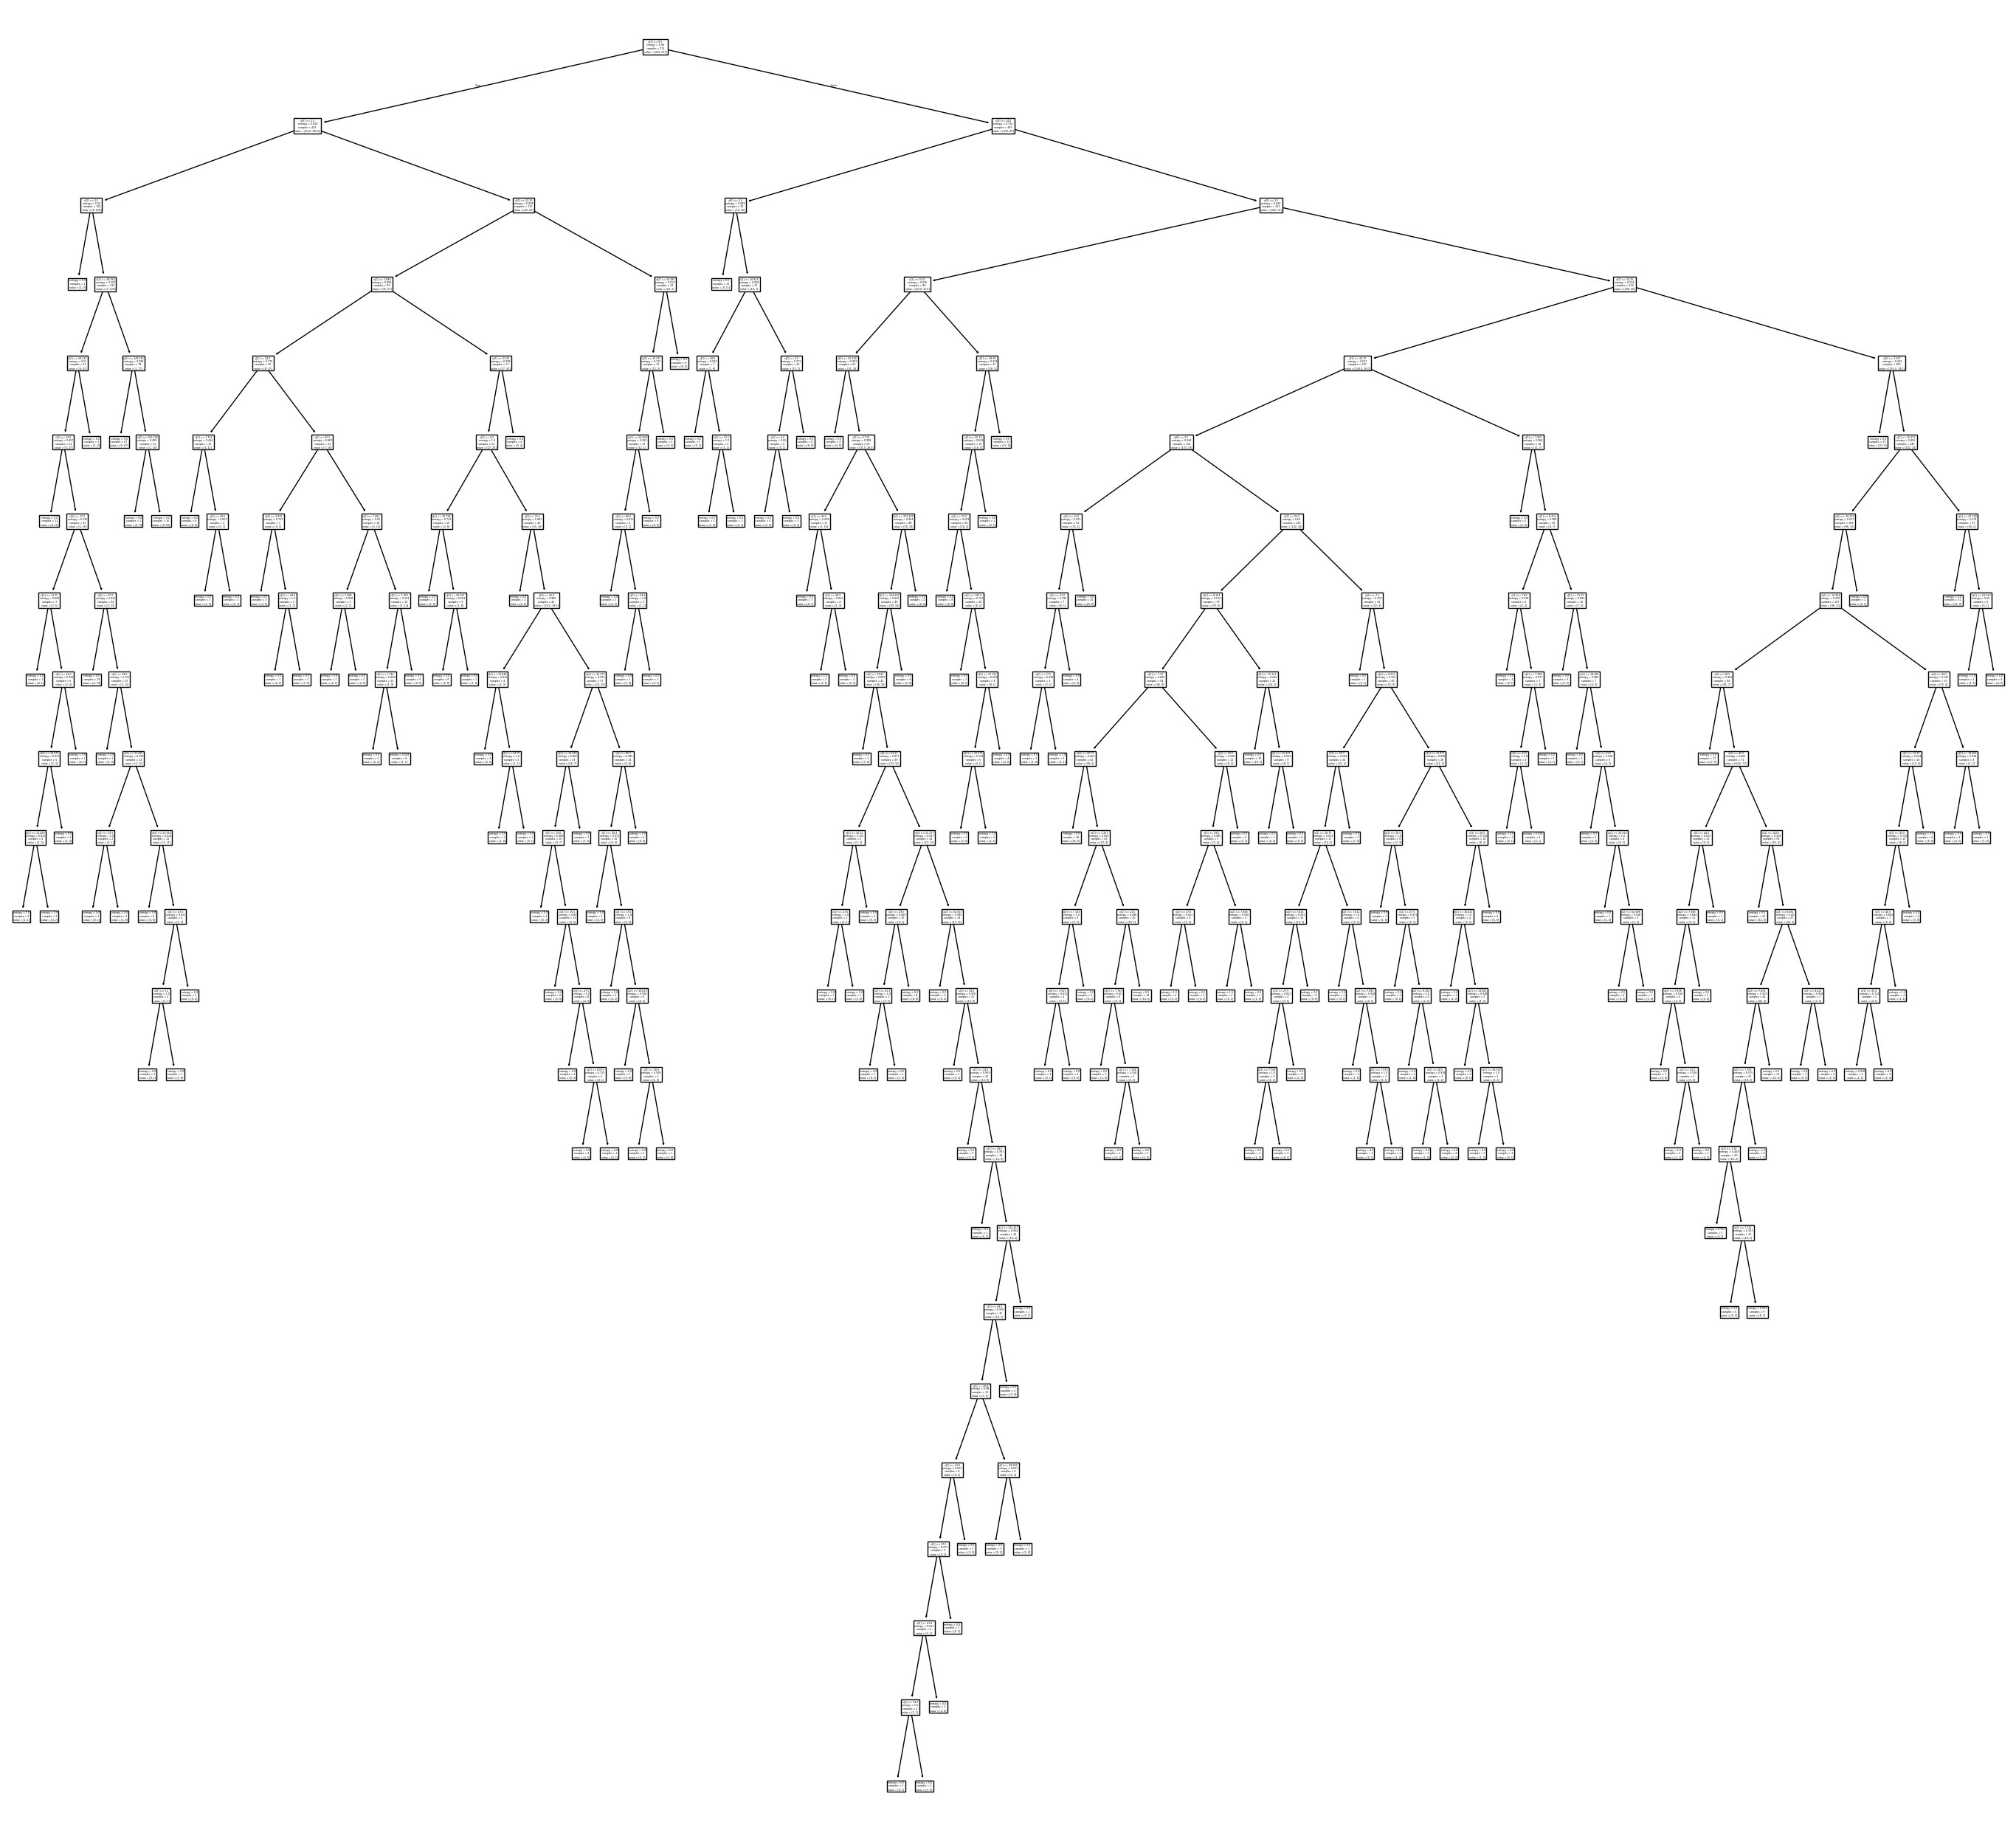

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(35,32))
tree.plot_tree(classifier)